In [ ]:
!pip install video2images


In [ ]:
from video2images import Video2Images


Video2Images(video_filepath="/content/0.mp4",
             out_dir="/content/photos")


 Video Duration is 0hr: 5min: 19sec 
 The input Video FPS is 25 frames/sec
 Capture rate is default FPS of input video i.e 25 frames/sec


 Capturing Frames... : 100%|█████████▉| 7998/8000 [00:56<00:00, 142.27iter/s]

 Done. Total frames captured: 7998 


zxc

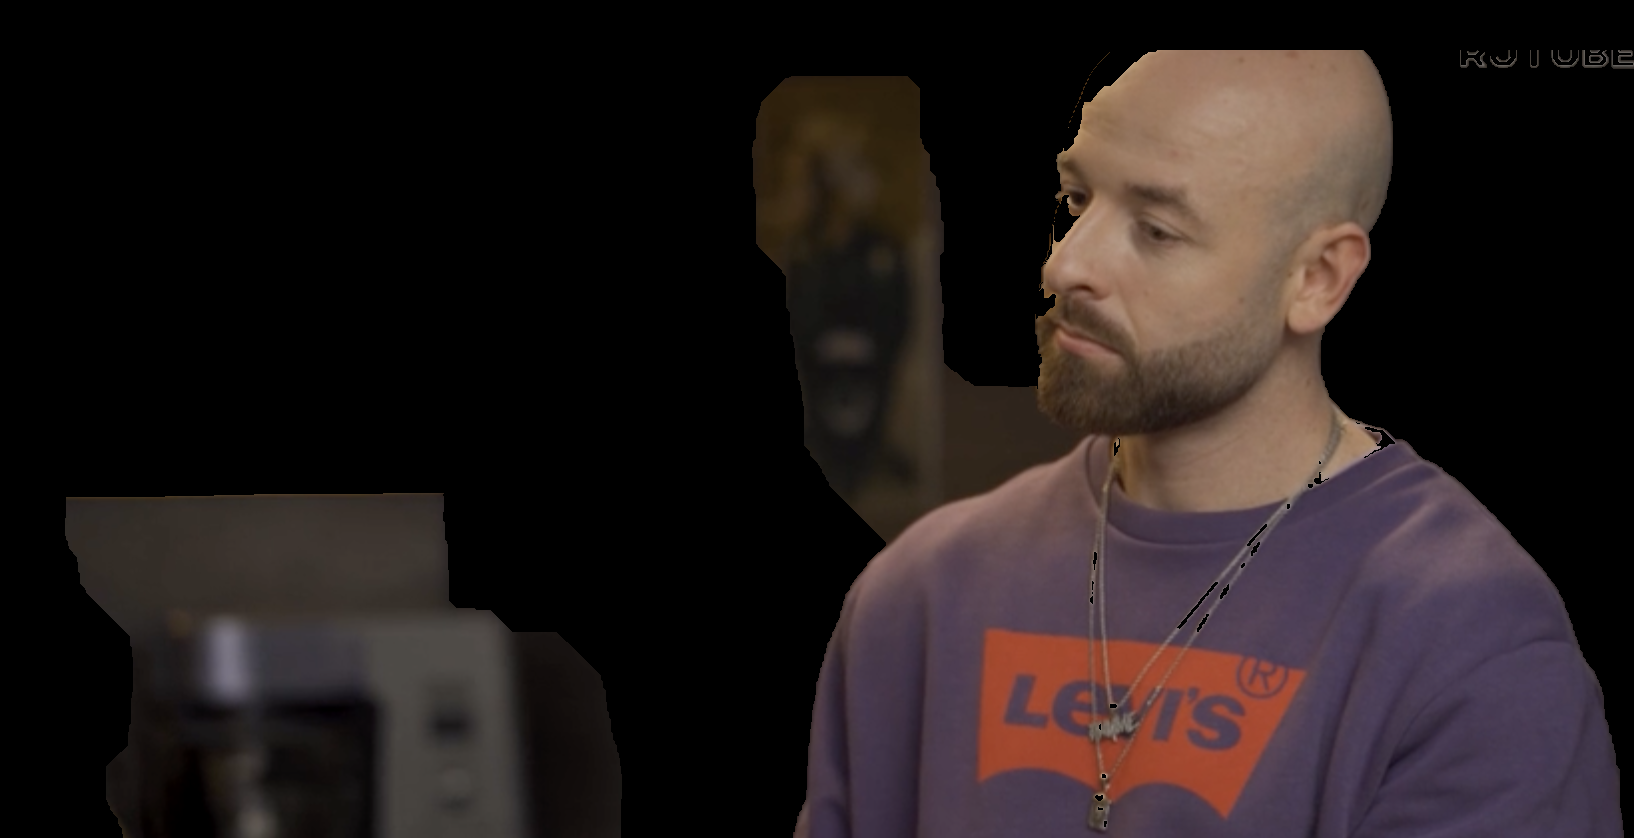

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def remove_background(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Создание маски
    mask = np.zeros(image.shape[:2], np.uint8)

    # Определение прямоугольной области, содержащей объект
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    rect = (50, 50, image.shape[1] - 50, image.shape[0] - 50)

    # Применение алгоритма GrabCut для удаления фона
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Создание маски, где 0 и 2 - фон, 1 и 3 - объект
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Применение маски к оригинальному изображению
    image_with_bg_removed = image * mask2[:, :, np.newaxis]

    # Возвращение изображения без фона
    return image_with_bg_removed

# Пример использования функции
image_path = '/content/zxc.png'
result = remove_background(image_path)

# Отображение результата
cv2_imshow(result)




In [ ]:
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
from rembg import remove

input_path = '/content/zxc.png'
output_path = '/content/output.png'

with open(input_path, 'rb') as i:
    with open(output_path, 'wb') as o:
        input = i.read()
        output = remove(input)
        o.write(output)

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 63.0GB/s]


In [ ]:
# @title Текст заголовка по умолчанию
def remove(
    data: Union[bytes, PILImage, np.ndarray],
    alpha_matting: bool = False,
    alpha_matting_foreground_threshold: int = 240,
    alpha_matting_background_threshold: int = 10,
    alpha_matting_erode_size: int = 10,
    session: Optional[BaseSession] = None,
    only_mask: bool = False,
    post_process_mask: bool = False,
    bgcolor: Optional[Tuple[int, int, int, int]] = None,
    *args: Optional[Any],
    **kwargs: Optional[Any]
) -> Union[bytes, PILImage, np.ndarray]:
    """
    Remove the background from an input image.


    This function takes in various parameters and returns a modified version of the input image with the background removed. The function can handle input data in the form of bytes, a PIL image, or a numpy array. The function first checks the type of the input data and converts it to a PIL image if necessary. It then fixes the orientation of the image and proceeds to perform background removal using the 'u2net' model. The result is a list of binary masks representing the foreground objects in the image. These masks are post-processed and combined to create a final cutout image. If a background color is provided, it is applied to the cutout image. The function returns the resulting cutout image in the format specified by the input 'return_type' parameter.


    Parameters:
        data (Union[bytes, PILImage, np.ndarray]): The input image data.
        alpha_matting (bool, optional): Flag indicating whether to use alpha matting. Defaults to False.
        alpha_matting_foreground_threshold (int, optional): Foreground threshold for alpha matting. Defaults to 240.
        alpha_matting_background_threshold (int, optional): Background threshold for alpha matting. Defaults to 10.
        alpha_matting_erode_size (int, optional): Erosion size for alpha matting. Defaults to 10.
        session (Optional[BaseSession], optional): A session object for the 'u2net' model. Defaults to None.
        only_mask (bool, optional): Flag indicating whether to return only the binary masks. Defaults to False.
        post_process_mask (bool, optional): Flag indicating whether to post-process the masks. Defaults to False.
        bgcolor (Optional[Tuple[int, int, int, int]], optional): Background color for the cutout image. Defaults to None.
        *args (Optional[Any]): Additional positional arguments.
        **kwargs (Optional[Any]): Additional keyword arguments.


    Returns:
        Union[bytes, PILImage, np.ndarray]: The cutout image with the background removed.
    """
    if isinstance(data, PILImage):
        return_type = ReturnType.PILLOW
        img = data
    elif isinstance(data, bytes):
        return_type = ReturnType.BYTES
        img = Image.open(io.BytesIO(data))
    elif isinstance(data, np.ndarray):
        return_type = ReturnType.NDARRAY
        img = Image.fromarray(data)
    else:
        raise ValueError("Input type {} is not supported.".format(type(data)))


    putalpha = kwargs.pop("putalpha", False)


    # Fix image orientation
    img = fix_image_orientation(img)


    if session is None:
        session = new_session("u2net", *args, **kwargs)


    masks = session.predict(img, *args, **kwargs)
    cutouts = []


    for mask in masks:
        if post_process_mask:
            mask = Image.fromarray(post_process(np.array(mask)))


        if only_mask:
            cutout = mask


        elif alpha_matting:
            try:
                cutout = alpha_matting_cutout(
                    img,
                    mask,
                    alpha_matting_foreground_threshold,
                    alpha_matting_background_threshold,
                    alpha_matting_erode_size,
                )
            except ValueError:
                if putalpha:
                    cutout = putalpha_cutout(img, mask)
                else:
                    cutout = naive_cutout(img, mask)
        else:
            if putalpha:
                cutout = putalpha_cutout(img, mask)
            else:
                cutout = naive_cutout(img, mask)


        cutouts.append(cutout)


    cutout = img
    if len(cutouts) > 0:
        cutout = get_concat_v_multi(cutouts)


    if bgcolor is not None and not only_mask:
        cutout = apply_background_color(cutout, bgcolor)


    if ReturnType.PILLOW == return_type:
        return cutout


    if ReturnType.NDARRAY == return_type:
        return np.asarray(cutout)


    bio = io.BytesIO()
    cutout.save(bio, "PNG")
    bio.seek(0)


    return bio.read()

NameError: ignored

In [ ]:
!pip install diffusers accelerate safetensors transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00


In [ ]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

url = "/content/zxc.png"
def download_image(url):
    image = PIL.Image.open(url)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "turn him into cyborg"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

AttributeError: ignored

  0%|          | 0/10 [00:00<?, ?it/s]

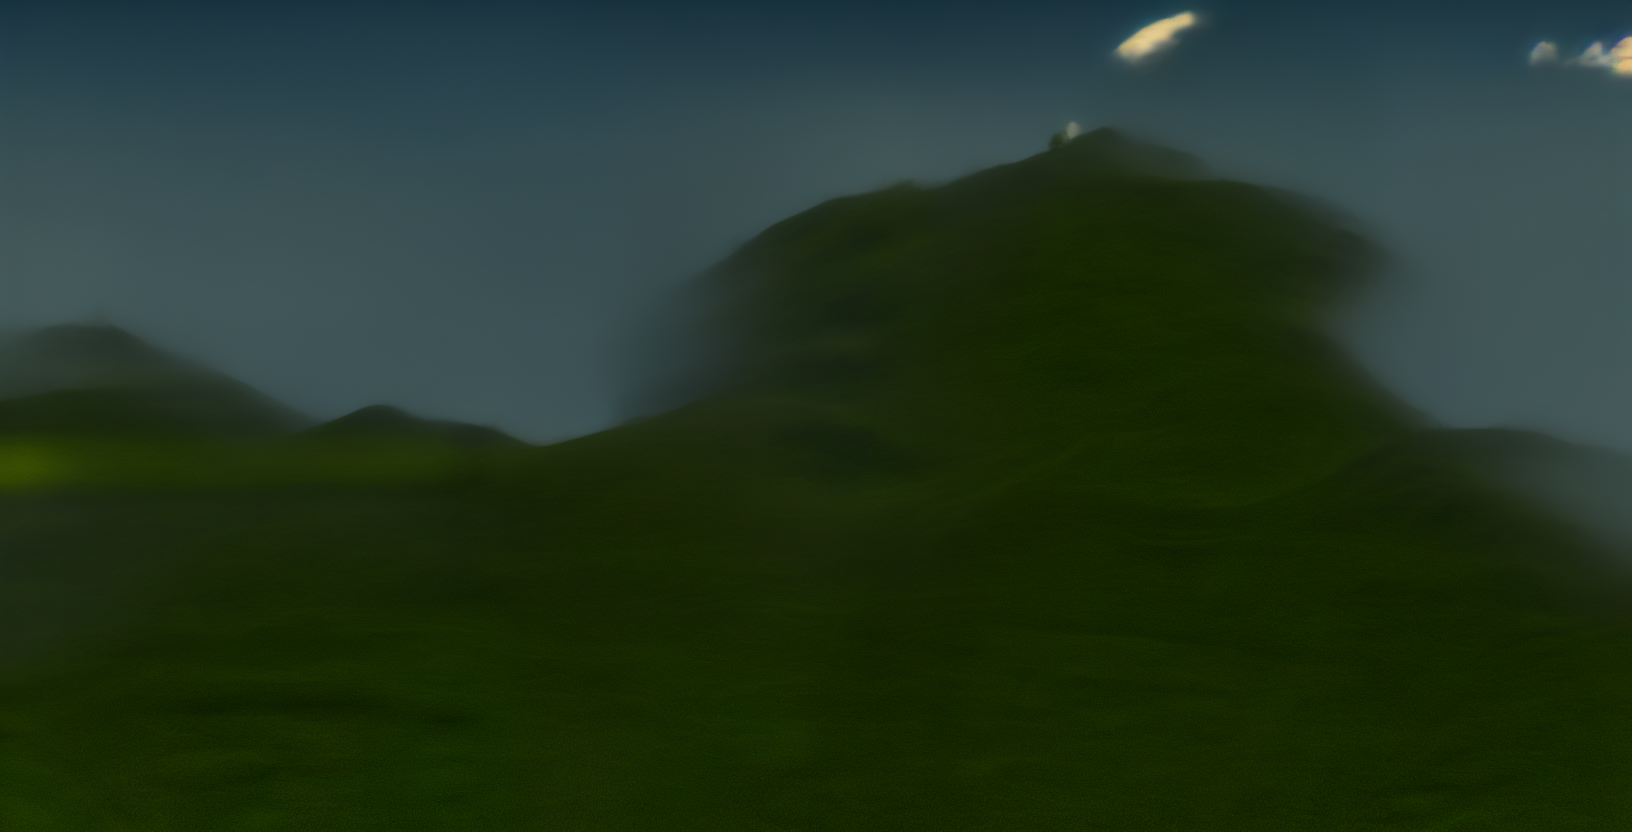

In [ ]:
url = "/content/zxc.png"
def download_image(url):
    image = PIL.Image.open(url)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "swap background to the hill"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]

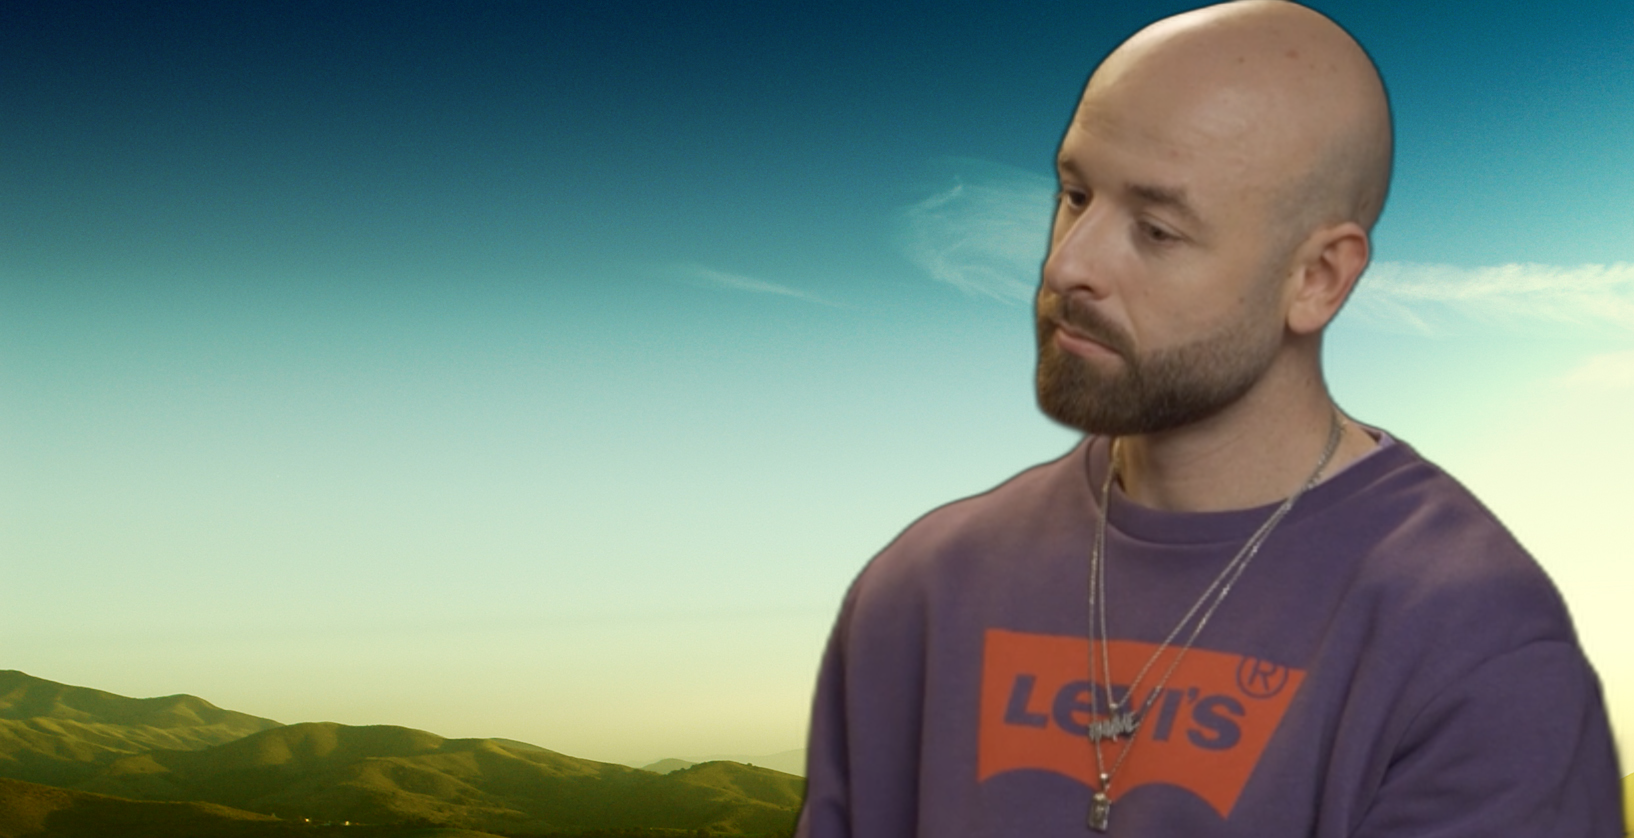

In [ ]:
from PIL import Image

img = Image.new('RGB', (1634, 838))
img1 = Image.open('/content/californian_hills_scenery.jpg')
img.paste(img1)
img2 = Image.open('/content/156db0b3-ca45-4970-b436-80c0b67b002b.png')
img.paste(img2, (0,0), img2)


img

С НУЛЯ:  ПОСОБИЕ ПО ВЫЖИВАНИЮ В АЛЬТЕРНАТИВНОМ МИРЕ

In [6]:
%pip install diffusers accelerate safetensors transformers matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/af/f3/fb27b3b902fc759bbca3f9d0336c48069c3022e57552c4b0095d997c7ea8/matplotlib-3.8.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/2c/8e/656f8e7cd316aa68d9824744773e90dbd71f847429d10c82001e927480a2/contourpy-1.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/49/ba/ebe5599acf47371393191091ae95fca08eb6f12fd151b52c8dbebb990d25/fonttools-4.43.1-cp311-cp311-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 868.9 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency 

In [1]:
%pip install rembg

Note: you may need to restart the kernel to use updated packages.


In [4]:
from rembg import remove

input_path = '/Users/daniilnikiforov/MLphotos/input/input.jpg'
output_path = '/Users/daniilnikiforov/MLphotos/output/output.png'

with open(input_path, 'rb') as inp:
    with open(output_path, 'wb') as out:
        inputx = inp.read()
        output = remove(inputx)
        out.write(output)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 217GB/s]


In [5]:
import cv2
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

class Model:
  def __init__(self):
    self.model_id = "stabilityai/stable-diffusion-2-1"
    self.model = self.__build_model()

  def __build_model(self):
    pipe = StableDiffusionPipeline.from_pretrained(self.model_id) #, torch_dtype=torch.float16
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    model = pipe.to("cpu") #mps убивает оперативку
    return pipe

class ImageDisplay:
  def showI(image):
    plt.axis("off")
    plt.imshow(image)
    plt.show()

modell = Model().model

a = modell((input("Prompt: ")), num_inference_steps=200, height=480, width=856).images
a[0].save("/Users/daniilnikiforov/MLphotos/prompt.png")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

: 

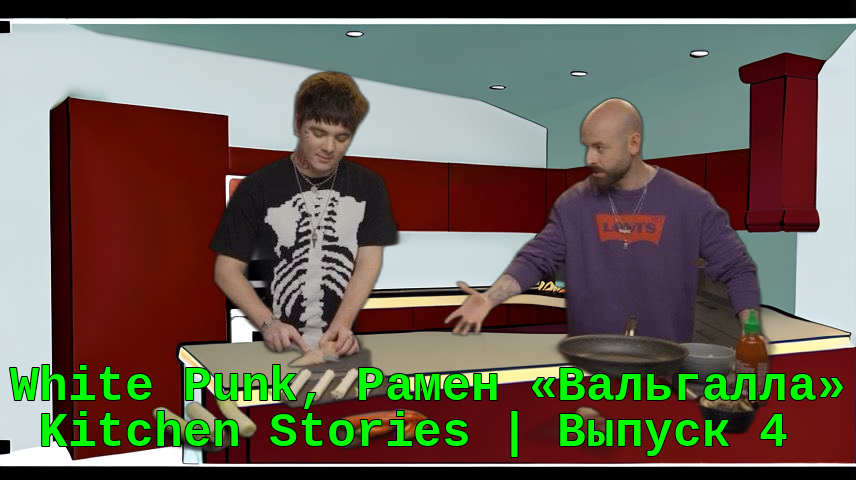

In [58]:
from PIL import Image

img = Image.new('RGB', (856, 480))
img1 = Image.open('/Users/daniilnikiforov/MLphotos/prompt.png')
img.paste(img1)
img2 = Image.open('/Users/daniilnikiforov/MLphotos/output/output.png')
img.paste(img2, (0,0), img2)


# Add Text to an image

I1 = ImageDraw.Draw(img)
fonts = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 48)

txt = "White Punk, Рамен «Вальгалла» | Kitchen Stories | Выпуск 4"
text = ""
j = 0
for i in txt:
  if j<=29:
    text+=i
    j+=1
  else:
    text+="\n"+i
    j=0
# text = "".join(i for i in txt if j <= 30) + "\n" + "".join(i for i in txt if j > 30)


I1.text((866-856/1, 480-480/4),text, font=fonts, fill=(0, 255, 0), stroke_width = 1, stroke_fill =(0, 0, 0) )

img